In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import csv
import time
import string
import requests
import pandas as pd
import datetime as dt

Mounted at /content/drive


In [23]:
def fetch_data():
    data=[]
    api_url = "https://storeviews-cdn.risedomain-prod.nikecloud.com/store-locations-static.json"
    response = requests.get(api_url).json()
    stores = response.get("stores")
    for store in stores:
        store = stores[f"{store}"]
        store_number = store.get("storeNumber")
        store_url = "https://www.nike.com/retail/s/" + store.get("slug")
        name = store.get("name")
        facility_type = store.get("facilityType")
        street = (
            store.get("address").get("address1")
            + " "
            + store.get("address").get("address2")
            + " "
            + store.get("address").get("address3")
        )
        city = store.get("address").get("city")
        state = store.get("address").get("state")
        country = store.get("address").get("iso2Country")
        postal_code = store.get("address").get("postalCode")
        phone = store.get("phone")
        latitude = store.get("coordinates").get("latitude")
        longitude = store.get("coordinates").get("longitude")
        hours = parse_hours(store)
        complete_address = street + " " + city + " " + state + " " + postal_code
        data.append(
            [
                store_number,
                store_url,
                name,
                street,
                city,
                state,
                postal_code,
                country,
                phone,
                facility_type,
                latitude,
                longitude,
                hours,
                complete_address,
            ]
        )
    return data


**Unparsed Hours:**  

{'monday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'tuesday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'wednesday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'thursday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'friday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'saturday': [{'startTime': '10:00', 'duration': 'PT11H'}], 'sunday': [{'startTime': '11:00', 'duration': 'PT8H'}]}








In [24]:
def parse_hours(store):
    days = [
        "monday",
        "tuesday",
        "wednesday",
        "thursday",
        "friday",
        "saturday",
        "sunday",
    ]
    hoos = store.get("operationalDetails").get("hoursOfOperation").get("regularHours")
    #print(f'Unparsed Hours: {hoos}')
    all_hours = []
    for day in days:
        try:
            start_time = hoos[f"{day}"][0]["startTime"]
            duration = hoos[f"{day}"][0]["duration"]
            duration = duration.split("H")[0].replace("PT", "")
            end_time = add_hours(start_time, int(duration))
            all_hours.append(f"{day}:{start_time} - {end_time}")
        except:
            all_hours.append(f"{day}:Closed")
    hoo = ", ".join(all_hours)
    return hoo


In [25]:
def add_hours(time_string, hr):
    the_time = dt.datetime.strptime(time_string, "%I:%M")
    new_time = the_time + dt.timedelta(hours=hr)
    return new_time.strftime("%I:%M")

 ***Start The Crawler***

In [26]:
start_time = dt.datetime.now() #Crawler started to fetch the data.
stores_list = fetch_data()
end_time = dt.datetime.now() #All the Nike stores are fetched, crawler ended.
elapsed_time = (end_time - start_time).total_seconds()
elapsed_time = round(elapsed_time, 1)
print(f"The script took {elapsed_time} seconds to run.")

The script took 0.4 seconds to run.


In [27]:
df = pd.DataFrame (stores_list, columns = ["store_number","store_url","name","street","city","state","postal_code","country","phone","facility_type","latitude","longitude","hours","complete_address"])
df.to_csv("/content/drive/MyDrive/DSSGx/nike_stores.csv", index=False)
print(f'The Total Number of Nike Stores Worldwide: {len(df.index)}')

The Total Number of Nike Stores Worldwide: 1953


In [28]:
print(df["store_url"].head(3))

0    https://www.nike.com/retail/s/nike-clearance-s...
1    https://www.nike.com/retail/s/nike-factory-sto...
2         https://www.nike.com/retail/s/nike-hd-muyeok
Name: store_url, dtype: object


 **Data Insights**

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

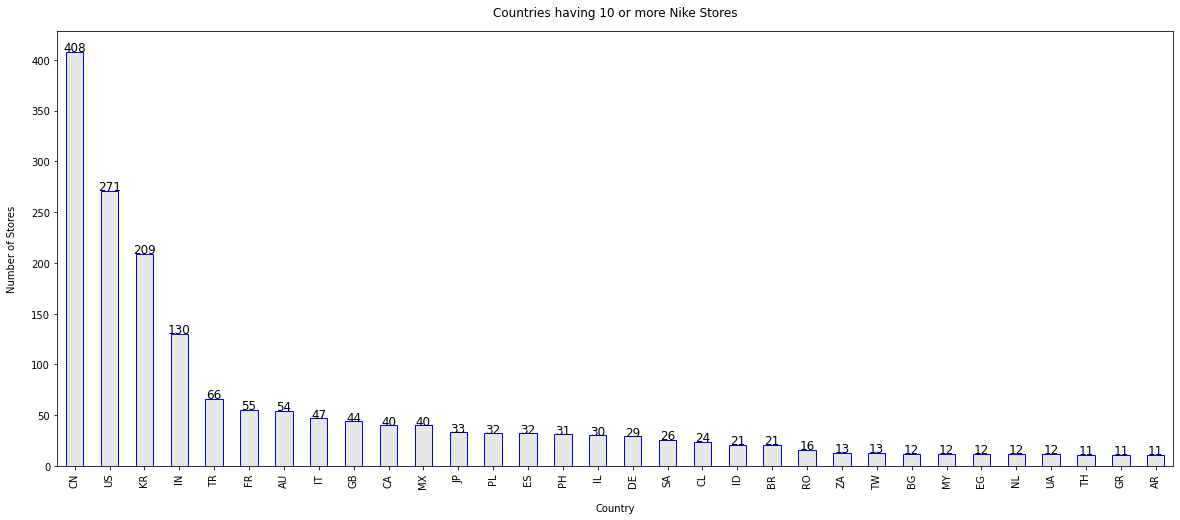

In [30]:
# Filter the DataFrame to only include countries with 50 or more stores
counts = df["country"].value_counts()
mask = counts >= 10

# Use the boolean series to filter the DataFrame
temp_df = df[df["country"].isin(counts[mask].index)]

# Plot the bar chart
ax =temp_df['country'].value_counts().plot(kind='bar', figsize=(20, 8), color=(0.1, 0.1, 0.1, 0.1),  edgecolor='blue')

# Add a title and axis labels
plt.xlabel("Country", labelpad=14)
plt.ylabel("Number of Stores", labelpad=14)
plt.title("Countries having 10 or more Nike Stores", y=1.02);
ax.set_facecolor("white")

for i, count in enumerate(counts[mask]):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=12)

# Show the plot
plt.show()

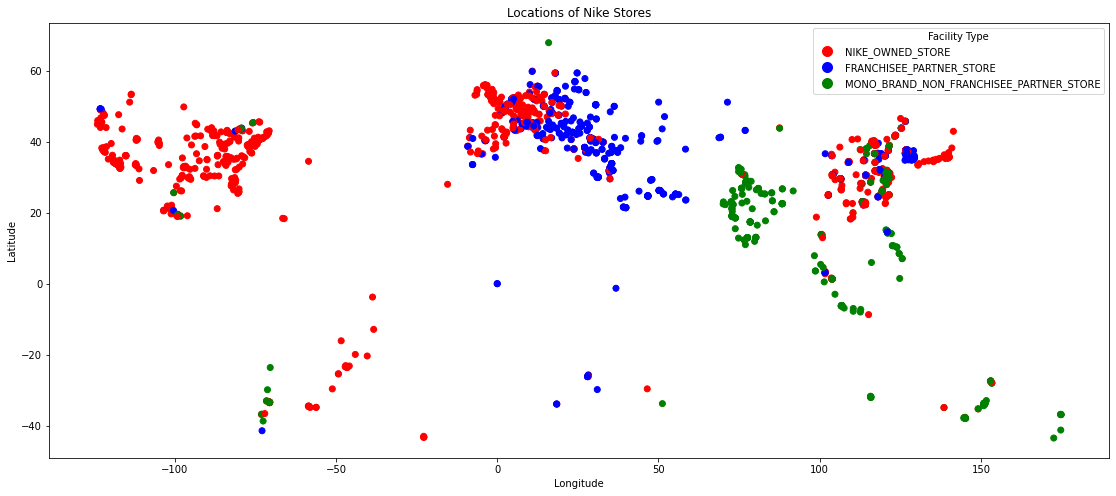

In [31]:
# Create a scatter plot of the stores
plt.figure(figsize=(19, 8))

# Create a different color for each facility type
colors = {'NIKE_OWNED_STORE': 'red', 'FRANCHISEE_PARTNER_STORE': 'blue', 'MONO_BRAND_NON_FRANCHISEE_PARTNER_STORE': 'green'}
df['color'] = df['facility_type'].map(colors)

# Plot the stores with different colors for each facility type
plt.scatter(df['longitude'], df['latitude'], c=df['color'])

# Add a title and labels for the x and y axes
plt.title('Locations of Nike Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a legend to show which color represents which facility type
legend_handles = [plt.plot([], [], color=color, marker="o", markersize=10, linewidth=0, label=type_)[0] for type_, color in colors.items()]
plt.legend(handles=legend_handles, title='Facility Type')

# Show the plot
plt.show()


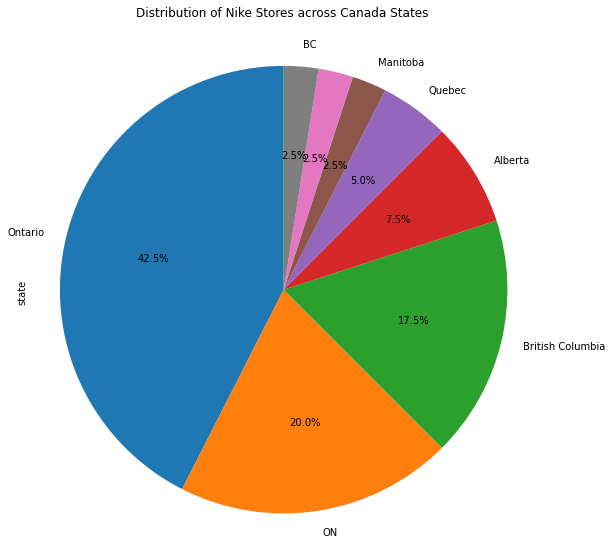

In [32]:
# Filter the DataFrame to only include US stores
df_us = df[df['country'] == 'CA']

# Count the number of stores in each state
state_counts = df_us["state"].value_counts()

# Plot the pie chart
ax = state_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(9, 9))

# Add a title and axis labels
plt.title("Distribution of Nike Stores across Canada States", y=1.05)
plt.axis('equal')

# Show the plot
plt.show()